# Running Sentiment Analysis on IL, GA, TX Tweets during shutdown and reopening  phases

Used Vader Sentiment Analysis to conduct sentiment analysis on all tweets. 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import pytz

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Link to this Sentiment Analyzer: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [57]:
tqdm.pandas() # Allows us to see progress bars on pandas.apply methods

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [58]:
style.use('fivethirtyeight')

In [59]:
# Reading in state shutdown data

# il_shutdown_df = pd.read_csv('./data/shutdown_data/IL_full_shutdown.csv', low_memory=False, index_col='date')
# ga_shutdown_df = pd.read_csv('./data/shutdown_data/GA_full_shutdown.csv', low_memory=False, index_col='date')
tx_shutdown_df = pd.read_csv('./data/shutdown_data/TX_full_shutdown.csv', low_memory=False, index_col='date')
# mi_shutdown_df = pd.read_csv('./data/sentiment_data/MI_shutdown_sentiment.csv', low_memory=False, index_col='date')

In [60]:
# Reading in state reopening data

# il_reopen_df = pd.read_csv('./data/reopening_data/IL_full_reopen.csv', low_memory=False, index_col='date')
# ga_reopen_df = pd.read_csv('./data/reopening_data/GA_full_reopen.csv', low_memory=False, index_col='date')
# tx_reopen_df = pd.read_csv('./data/reopening_data/TX_full_reopen.csv', low_memory=False, index_col='date')
# mi_reopen_df = pd.read_csv('./data/sentiment_data/MI_reopen_sentiment.csv', low_memory=False, index_col='date')
# oh_reopen_df = pd.read_csv('./data/sentiment_data/OH_reopen_sentiment.csv', low_memory=False, index_col='date')

In [61]:
def set_index_datetime_in_timezone(data, timezone):
    '''
    Takes a list of dataframes formatted [dataframe, timezone]
    Sets index of each dataframe to datetime and sorts the dataframe
    
    See pytz.timezone() documentation for all acceptable timezones.
    For the US, use the following:
    
    US/Central
    US/Eastern
    US/Mountain
    US/Pacific
    '''
    
    # Create datetime in local timezone
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    data.index = data.index.tz_convert(timezone)


In [62]:
df_list = [
#     [il_shutdown_df, 'US/Central'],
#     [ga_shutdown_df, 'US/Eastern'],
    [tx_shutdown_df, 'US/Eastern'],
#     [mi_reopen_df, 'US/Eastern'],
#     [mi_shutdown_df, 'US/Eastern'],
#     [oh_reopen_df, 'US/Eastern']
#     [il_reopen_df, 'US/Central'],
#     [ga_reopen_df, 'US/Eastern'],
#     [tx_reopen_df, 'US/Eastern']
]

for df in df_list:
    set_index_datetime_in_timezone(df[0], df[1])

In [40]:
# il_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'springfield', 'pritzker', 'virus']
# ga_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'atlanta', 'kemp', 'virus']
# tx_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'abbott', 'virus']
mi_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'whittmer', 'whitmer', 'virus']
mi_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'ginter', 'ginther', 'virus']

In [13]:
# il_shutdown_df_covid = il_shutdown_df.copy()[il_shutdown_df['text'].str.contains('|'.join(il_covid_terms))]
# ga_shutdown_df_covid = ga_shutdown_df.copy()[ga_shutdown_df['text'].str.contains('|'.join(ga_covid_terms))]
# tx_shutdown_df_covid = tx_shutdown_df.copy()[tx_shutdown_df['text'].str.contains('|'.join(tx_covid_terms))]
mi_shutdown_df_covid = mi_shutdown_df.copy()[mi_shutdown_df['text'].str.contains('|'.join(mi_covid_terms))]

# il_reopen_df_covid = il_reopen_df.copy()[il_reopen_df['text'].str.contains('|'.join(il_covid_terms))]
# ga_reopen_df_covid = ga_reopen_df.copy()[ga_reopen_df['text'].str.contains('|'.join(ga_covid_terms))]
# tx_reopen_df_covid = tx_reopen_df.copy()[tx_reopen_df['text'].str.contains('|'.join(tx_covid_terms))]

In [41]:
# provided from link 
def sentiment_analyzer_scores(sentence):    
    score = analyser.polarity_scores(sentence)
    return score

In [63]:
# Analyze our city data
def vader_analyzer(data):
    '''
    Takes pandas dataframe of info scraped from twitter and performs sentiment
    analysis. Creates 5 new columns to be used in sentiment analysis:
    'neg_score' - negative score
    'neu_score' - neutral score
    'pos_score' - positive score
    'compound_score' - (score < -0.05 = negative
                        score between -0.05 and 0.05 = neutral
                        score > 0.05 = positive)
    '''
    data['sentiment_analysis'] = data.progress_apply(lambda x: sentiment_analyzer_scores(x['text']), axis=1)
    data['neg_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neg'])
    data['neu_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neu'])
    data['pos_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['pos'])
    data['compound_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['compound'])

In [43]:
def create_time_cols(data, timezone):
    # Creating month_day_hour column for graphing purposes
    data['month_day_hour'] = data.index.strftime(date_format='%m%d%H')

In [50]:
def plot_state_sentiment(data, timezone, covid_only=False, is_reopen=False):
#     # Creating this variable for x tick marks
    hour_group = data.resample('h').mean()[['compound_score']]
    hour_group['hour_ord'] = range(0, len(hour_group)) # Hour ordinal column for graphing
    days = data.resample('D').mean().index.strftime('%m-%d')
    
    # Stores the shutdown and reopening dates as YYYYMMDD integers
    timeline_dict = {
        'FL': ['2020-04-01', '2020-04-29'],
        'TX': ['2020-03-31', '2020-05-18'],
        'NJ': ['2020-03-16', '2020-06-09'],
        'NY': ['2020-03-22', '2020-06-13'],
        'IL': ['2020-03-20', '2020-05-29'],
        'GA': ['2020-04-02', '2020-06-01'],
        'OH': ['2020-03-22', '2020-05-12'],
        'MI': ['2020-03-23', '2020-06-01']
    }
    
    # Stores the timezone offset
    timezone_map = {'eastern': -4,
                'central': -5,
                'mountain': -6,
                'pacific': -7}

    # Create sentiment plot
    fig, ax = plt.subplots(figsize=(32, 6))

    sns.lineplot(data=data,
                 x='month_day_hour',
                 y='compound_score', 
                 linewidth=2.5, 
                 color='blue',
                )

    plt.axhspan(-.05, .05, color='gray', alpha=0.3)
    plt.axhspan(.05, np.percentile(data['compound_score'], 90), color='green', alpha=0.3)
    plt.axhspan(-.05, np.percentile(data['compound_score'], 10), color='red', alpha=0.3)

    plt.xticks(range(-(24 + timezone_map[timezone]), # Need to offset the xticks to account for timezone shift upon scraping 
                         len(hour_group), # hour_group is just the original data grouped by hour, should be divisible by 24
                         24),
                   days.unique())

    ticks = ax.get_xticks().tolist()
    
    # Sorry this isn't human readable :( it returns the date in the proper format to be plotted
    plt.axvline(hour_group[timeline_dict[data['state'][0]][is_reopen]]['hour_ord'][0]) 
    
    plt.legend(['_', 'Date shutdown was announced'])
    
    # If the state is reopened
    if is_reopen:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around Bars Reopening Announcement')
        if covid_only:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around Bars Reopening Announcement')
        else:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} General Tweet Sentiment Over Time Around Bars Reopening Announcement')
    
    # If the state is not reopened
    else:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around State Shutdown Announcement')
        if covid_only:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around State Shutdown Announcement')
        else:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} General Tweet Sentiment Over Time Around State Shutdown Announcement')
            
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.show();

In [51]:
def analyze_and_plot_sentiment(data, timezone, covid_only=False, is_reopen=False):
    vader_analyzer(data)
    create_time_cols(data, timezone)
    plot_state_sentiment(data, timezone, covid_only, is_reopen)

In [34]:
# list is formatted as data, timezone, is_reopencentral
covid_term_data = [
    [il_shutdown_df_covid, 'central', False],
    [il_reopen_df_covid, 'central', True], 
    [ga_shutdown_df_covid, 'eastern', False],
    [ga_reopen_df_covid, 'eastern', True],
    [tx_shutdown_df_covid, 'eastern', False],
    [tx_reopen_df_covid, 'eastern', True]
]

NameError: name 'il_shutdown_df_covid' is not defined

In [64]:
# Initializing Vader model 
analyser = SentimentIntensityAnalyzer()

## **Sentiment in Covid-specific tweets during shutdown and reopening phases**

In [52]:
# Iterates through each item in covid_term_data and runs it through analyze_and_plot_sentiment

for i in range(len(covid_term_data)):
    analyze_and_plot_sentiment(covid_term_data[i][0], # data
                               covid_term_data[i][1], # timezone
                               covid_only=True, # search terms
                               is_reopen=covid_term_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

NameError: name 'covid_term_data' is not defined

In [65]:
# Dataframe, timezone, boolean for is_reopen
general_terms_data = [
#     [il_shutdown_df, 'central', False],
#     [il_reopen_df, 'central', True], 
#     [ga_shutdown_df, 'eastern', False],
#     [ga_reopen_df, 'eastern', True],
    [tx_shutdown_df, 'eastern', False],
#     [tx_reopen_df, 'eastern', True],
#     [mi_reopen_df, 'eastern', True],
#     [mi_shutdown_df, 'eastern', False],
#     [oh_reopen_df, 'eastern', True]
]

## **General Sentiment from Tweets during shutdown and reopening phases**

100%|██████████| 37458/37458 [00:00<00:00, 1170315.98it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000022B4A20EA88> has a label of '_' which cannot be automatically added to the legend.


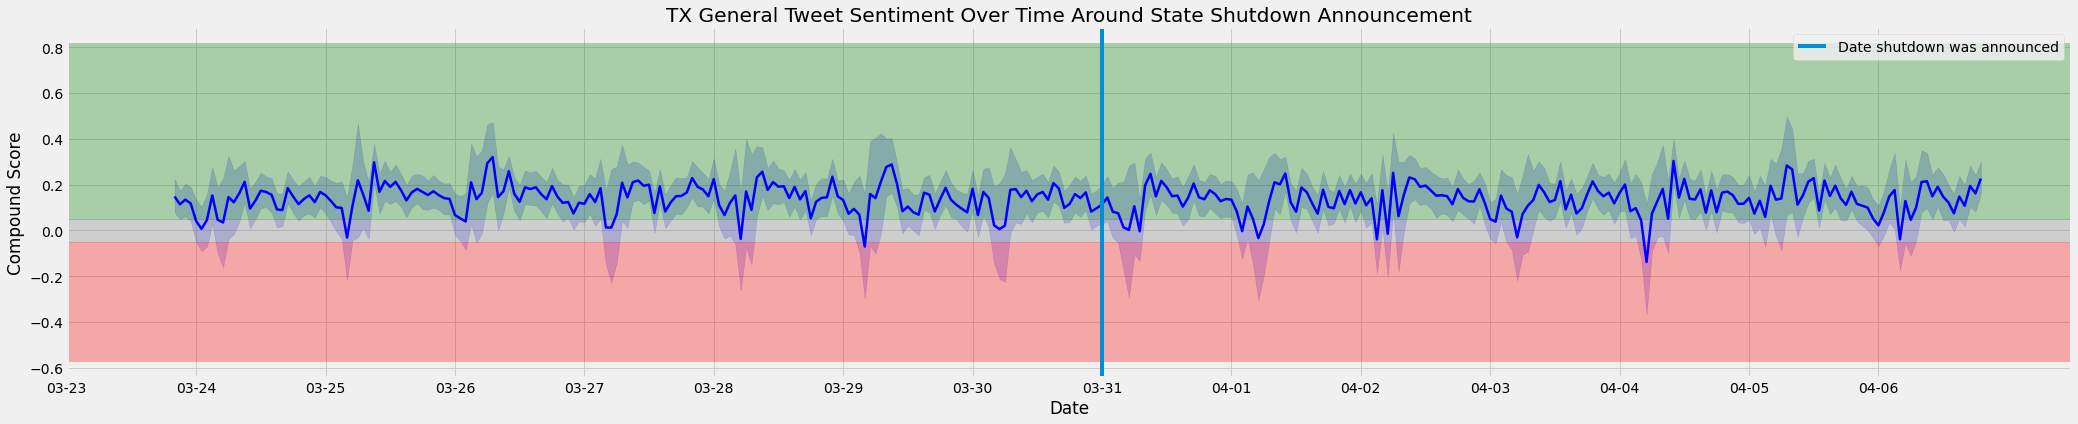

In [66]:
for i in range(len(general_terms_data)):
    analyze_and_plot_sentiment(general_terms_data[i][0], # data
                               general_terms_data[i][1], # timezone
                               covid_only=False, # search terms
                               is_reopen=general_terms_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

In [67]:
# il_shutdown_df.to_csv('./data/sentiment_data/IL_shutdown_sentiment.csv')
# ga_shutdown_df.to_csv('./data/sentiment_data/GA_shutdown_sentiment.csv')
tx_shutdown_df.to_csv('./data/sentiment_data/TX_shutdown_sentiment.csv')
# mi_reopen_df.to_csv('./data/sentiment_data/MI_reopen_sentiment.csv')
# mi_shutdown_df.to_csv('./data/sentiment_data/MI_shutdown_sentiment.csv')

# oh_reopen_df.to_csv('./data/sentiment_data/OH_reopen_sentiment.csv')
# il_reopen_df.to_csv('./data/sentiment_data/IL_reopen_sentiment.csv')
# ga_reopen_df.to_csv('./data/sentiment_data/GA_reopen_sentiment.csv')
# tx_reopen_df.to_csv('./data/sentiment_data/TX_reopen_sentiment.csv')